In [1]:
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) 

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score

import os
os.chdir('../')

from utils import BERTEmbExtractor, find_best_ccp_aplpha, metrics, FaissExtractor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import joblib
import torch

tqdm.pandas()

data_path = '/home/admin01/vadim/classifier/data'

data = pd.read_csv(data_path + '/' + 'Таблица_данные_опроса_+_часть_из_обогащения_v_2.csv')
data = data.drop(columns=['ИНН', 'Степень уверенности', 'Кол-во вариантов с таким названием компании'])

# df_full = pd.read_excel(data_path + '/Выгрузка_Классификатор_для_передачи_1_заход.xlsx')
# cols_to_use = data.columns.difference(df_full.columns).tolist()
# data = df_full.merge(data[['Номер'] + cols_to_use], on='Номер', how='left', copy=False)

data = data[data['Карьерная ступень по Классификатору ФОИР'] <= 11]
# data = data[data['Карьерная ступень по Классификатору ФОИР'] <= 5]


num_cols = ['Уставный капитал, сумма', 'Среднесписочная численность сотрудников', 'Сумма уплаченных налогов за 2020', 'age']

cat_cols = ['Вид экономической деятельности, ОКВЭД', 
            'Доп вид экономической деятельности_1',
            'Доп вид экономической деятельности_2', 
            'Доп вид экономической деятельности_3',
            'Уставный капитал, тип',
            'Тип по ОКОГУ',
            'Категория из реестра СМП'
            ]

tasks = ['Сфера деятельности по Классификатору ФОИР', 'Карьерная ступень по Классификатору ФОИР']
# tasks = ['Наименование выбранной типовой должности', 'Карьерная ступень по Классификатору ФОИР']


# extract age
data['Дата рождения'] = pd.to_datetime(data['Дата рождения'], format="%d.%m.%Y")
data['age'] = pd.Timestamp('now').year - data['Дата рождения'].dt.year

# work with target
LE = [LabelEncoder(), LabelEncoder()]
data['label_a'] = LE[0].fit_transform(data[tasks[0]])
data['label_b'] = LE[1].fit_transform(data[tasks[1]])

text_cols  = ['Место работы', 'Наименование текущей должности']
cat_cols += ['Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Федеральный округ']
data[text_cols] = data[text_cols].fillna('Пропущенное значение')

# split data
df = data.copy()

df_test = df[df['Ручная проверка карьерной ступени'].notna()][cat_cols + text_cols + num_cols ]
y_test = [df[df['Ручная проверка карьерной ступени'].notna()]['label_a'], 
          df[df['Ручная проверка карьерной ступени'].notna()]['label_b']]

df = df[df['Ручная проверка карьерной ступени'].isna()]
df_train, df_val = train_test_split(df, test_size=.20)

y_train = [df_train['label_a'], df_train['label_b']]
df_train = df_train[cat_cols + text_cols + num_cols + tasks].copy()

y_val = [df_val['label_a'], df_val['label_b']]
df_val = df_val[cat_cols + text_cols + num_cols + tasks].copy()

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Добавим faiss на похожесть типовым должностям

In [2]:
pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
n_pca = 100

import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = ['query: how much protein should a female eat',
               'query: 南瓜的家常做法',
               "passage: As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
               "passage: 1.清炒南瓜丝 原料:嫩南瓜半个 调料:葱、盐、白糖、鸡精 做法: 1、南瓜用刀薄薄的削去表面一层皮,用勺子刮去瓤 2、擦成细丝(没有擦菜板就用刀慢慢切成细丝) 3、锅烧热放油,入葱花煸出香味 4、入南瓜丝快速翻炒一分钟左右,放盐、一点白糖和鸡精调味出锅 2.香葱炒南瓜 原料:南瓜1只 调料:香葱、蒜末、橄榄油、盐 做法: 1、将南瓜去皮,切成片 2、油锅8成热后,将蒜末放入爆香 3、爆香后,将南瓜片放入,翻炒 4、在翻炒的同时,可以不时地往锅里加水,但不要太多 5、放入盐,炒匀 6、南瓜差不多软和绵了之后,就可以关火 7、撒入香葱,即可出锅"]

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T) * 100
print(scores.tolist())


Добавим поиск самых похожих типовых должностей


In [4]:
bert = BERTEmbExtractor(torch.device('cuda'), n_features=n_pca)
unique_type_name = pd.DataFrame(df['Наименование выбранной типовой должности'].unique())
type_name_emb = bert.fit_transform(unique_type_name).values
# bert = BERTEmbExtractor(torch.device('cuda'), n_features=161)
bert.columns = ['Наименование текущей должности']
name_emb = bert.fit_transform(df[['Наименование текущей должности']]).values

  0%|          | 0/6 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/6 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/1345 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is

In [5]:
type_name_emb.shape

(163, 100)

In [6]:
import faiss

vector_dimension = type_name_emb.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
index.add(type_name_emb)

In [7]:
distances, items = index.search(name_emb, k=3)

Добавим поиск похожих типовых имен компаний

In [8]:
work_name_df = pd.read_excel('/home/admin01/vadim/classifier/data/развернутый_список_фоив_роив_от_Кати.xlsx')

In [11]:
work_name_df['Название органа (полное)'][1:]

1       Министерство внутренних дел Российской Федерации
2      Министерство здравоохранения Российской Федерации
3      Министерство иностранных дел Российской Федерации
4             Министерство культуры Российской Федерации
5              Министерство обороны Российской Федерации
                             ...                        
628                                                  ФПП
629                                           Росгвардия
630                                                 ГУСП
631                               Социальный фонд России
632                                                  СФР
Name: Название органа (полное), Length: 632, dtype: object

In [13]:
len(work_name_df['Название органа (полное)'][1:].unique())

626

In [15]:
df

,Номер,Пол,Дата рождения,Федеральный округ,Регион,Страна проживания,Место работы,Наименование текущей должности,Уровень образования,Карьерная ступень по Классификатору ФОИР,Наименование выбранной типовой должности,Сфера деятельности по Классификатору ФОИР,Соответствует ли выбранная типовая текущей должности,Ручная проверка карьерной ступени,Разница по итогам проверки,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип","Уставный капитал, сумма",Тип по ОКОГУ,Среднесписочная численность сотрудников,Категория из реестра СМП,Сумма уплаченных налогов за 2020,age,label_a,label_b
0,9886272994,Мужской,1980-05-28,Центральный ФО,Московская,Россия,"ООО ""РЖД-Технологии""",Директор по стратегии,Кандидат наук,1,Руководитель подразделения/группы/команды на м...,"Коммерческие компании, государственные/муницип...",Можно считать аналогом с очень большой натяжкой,NaN,NaN,Деятельность консультативная и работы в област...,"Торговля оптовая компьютерами, периферийными у...",Торговля оптовая неспециализированная,"Торговля розничная компьютерами, периферийными...",УСТАВНЫЙ КАПИТАЛ,1.951980e+08,"Организации, учрежденные юридическими лицами и...",89.0,NaN,2.016288e+08,43.0,1,0
1,8010695393,Мужской,1977-10-09,Центральный ФО,Орловская,Россия,ПАО МегаФон,начальник,Два и более высших образований,3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,Деятельность в области связи на базе проводных...,Торговля оптовая программным обеспечением,Торговля оптовая неспециализированная,Деятельность в области связи на базе беспровод...,УСТАВНЫЙ КАПИТАЛ,6.200000e+07,Хозяйственные общества и товарищества с участи...,NaN,NaN,NaN,46.0,1,2
2,4851605917,Мужской,1991-12-08,Уральский ФО,Свердловская,Россия,"ООО ""Генная Хирургия""",Исполнительный директор,Два и более высших образований,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,Научные исследования и разработки в области ес...,Производство фармацевтических субстанций,Производство лекарственных препаратов и матери...,"Производство посуды для лабораторных, фармацев...",УСТАВНЫЙ КАПИТАЛ,8.400000e+04,"Организации, учрежденные юридическими лицами и...",0.0,МИКРОПРЕДПРИЯТИЕ,1.057117e+06,32.0,1,4
3,7512508692,Мужской,1980-01-19,Центральный ФО,Москва,Россия,ПАО «Вымпелком»,Директор по стратегии и долгосрочному планиров...,"Высшее, специалитет, магистратура",4,Руководитель управления корпоративной функции ...,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,Деятельность по предоставлению услуг подвижной...,Производство элементов электронной аппаратуры,Производство радиоэлектронных средств связи,Производство радио- и телевизионной передающей...,УСТАВНЫЙ КАПИТАЛ,2.885380e+05,Хозяйственные общества и товарищества с участи...,NaN,NaN,NaN,43.0,1,3
4,1007319237,Мужской,1976-01-11,Центральный ФО,Москва,Россия,Индивидуальный предприниматель,Предприниматель,"Высшее, специалитет, магистратура",1,Индивидуальный предприниматель/самозанятый,"Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43833,9101176879,Мужской,1986-01-01,Центральный ФО,Москва,Россия,Компания САР,Руководитель проекта,"Высшее, специалитет, магистратура",3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,Производство электроэнергии,Производство электроэнергии тепловыми электрос...,Производство пара и горячей воды (тепловой эне...,Строительство жилых и нежилых зданий,УСТАВНЫЙ КАПИТАЛ,2.773348e+09,"Организации, учрежденные юридическими лицами и...",459.0,NaN,2.193324e+08,37.0,1,2
43835,7582344260,Мужской,1

In [16]:
bert = BERTEmbExtractor(torch.device('cuda'), n_features=n_pca)
unique_work_name = pd.DataFrame(work_name_df['Название органа (полное)'][1:].unique())
work_name_emb = bert.fit_transform(unique_work_name).values
# bert = BERTEmbExtractor(torch.device('cuda'), n_features=161)
bert.columns = ['Место работы']
name_emb = bert.fit_transform(df[['Место работы']]).values

  0%|          | 0/20 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/20 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/1345 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it 

In [18]:
vector_dimension = work_name_emb.shape[1]
index_work = faiss.IndexFlatL2(vector_dimension)
index_work.add(work_name_emb)

In [ ]:
distances, items = index.search(name_emb, k=3)

In [12]:
col_target = 'Наименование выбранной типовой должности'
col_text = 'Наименование текущей должности'

In [13]:
from sklearn.impute import KNNImputer

In [14]:
# define pipelines and transformer
bert = BERTEmbExtractor(device=torch.device('cuda'), batch_size=32, n_features=n_pca)

data_transformer =  ColumnTransformer([
    ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('text_encoder', make_pipeline(bert, 
                                   PCA(n_pca)), text_cols),
    ('faiss_extractor', make_pipeline(bert, 
                                      FaissExtractor(index, k=10)), [col_text]),
    ('num_features', 'passthrough', num_cols)
    ], remainder='drop', verbose_feature_names_out=True)

data_prepare = Pipeline([
    ('preproc', data_transformer),
    ('imputer', KNNImputer()),
    ])

In [15]:
# prepare Xs
X_train = data_prepare.fit_transform(df_train)
X_val = data_prepare.transform(df_val)
X_test = data_prepare.transform(df_test)

  0%|          | 0/1076 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/1076 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/1076 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor,

In [16]:
X_train.shape

(34408, 136)

In [17]:
from sklearn.ensemble import StackingClassifier

Сфера деятельности по Классификатору ФОИР

Start compute cost_complexity_pruning_path


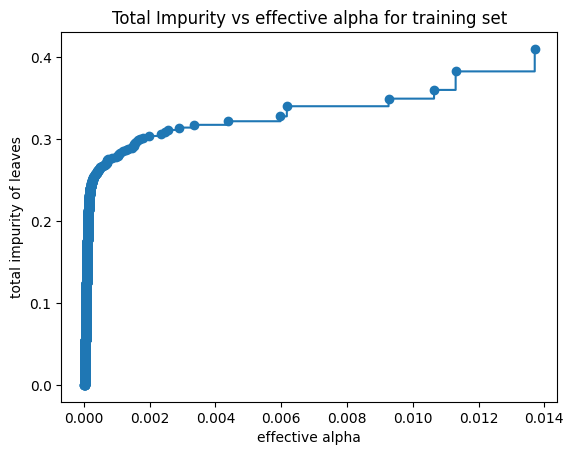

Start searching best ccp alphas


100%|██████████| 45/45 [01:25<00:00,  1.90s/it]


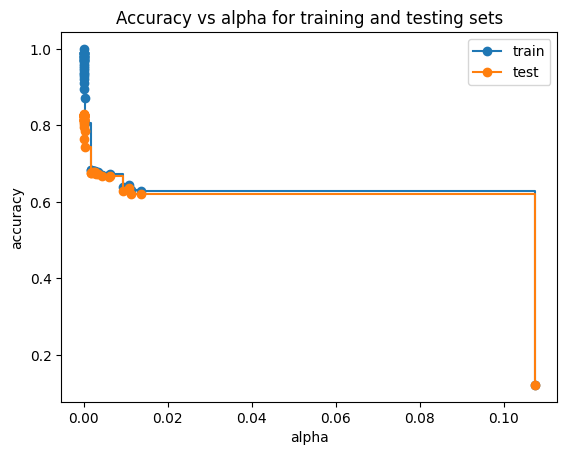

best accuracy val: train 0.9602127412229714 ,0.8292456119958154
Лучший коэф для прунинга 6.781368673951796e-05

Карьерная ступень по Классификатору ФОИР

Start compute cost_complexity_pruning_path


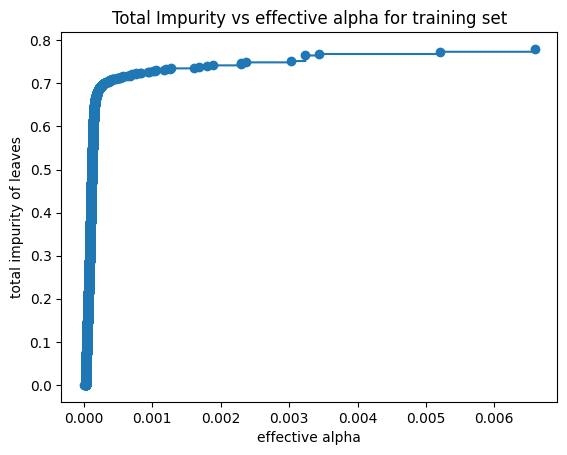

Start searching best ccp alphas


100%|██████████| 45/45 [03:24<00:00,  4.54s/it]


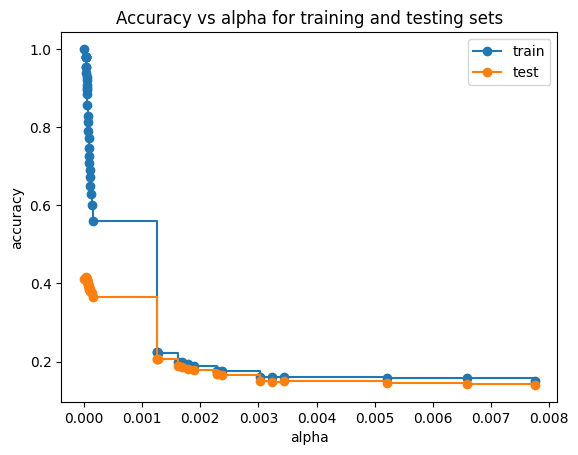

best accuracy val: train 0.9391129969774471 ,0.41555271416947576
Лучший коэф для прунинга 4.359451290397582e-05



In [18]:
# find best hyper params
pipes = []

for i, task in enumerate(tasks):
    print(task)
    print()
    
    
    if i <= 0:
        best_ccp = find_best_ccp_aplpha(X_train, y_train[i], X_val, y_val[i])
        
        
        pipe = ExtraTreesClassifier(class_weight='balanced_subsample', 
                                    oob_score=True, 
                                    bootstrap=True, 
                                    n_jobs=5, 
                                    ccp_alpha=best_ccp)
        
    else:
        y_pred = pipes[0].predict(X_train)
        best_ccp = find_best_ccp_aplpha(np.hstack([X_train, pipes[0].predict(X_train).reshape(-1, 1)]), y_train[i], 
                                        np.hstack([X_val, pipes[0].predict(X_val).reshape(-1, 1)]), y_val[i])
        
        pipe = StackingClassifier(estimators=[('pred_extract', pipes[0])], 
                                  final_estimator=ExtraTreesClassifier(class_weight='balanced_subsample', 
                                           oob_score=True,
                                           bootstrap=True, 
                                           n_jobs=5, 
                                           ccp_alpha=best_ccp), 
                                  cv='prefit',
                                  passthrough=True)
    
    # print('точность :', cross_val_score(pipe, X_train.copy(), y_train[i], n_jobs=1))
    pipe = pipe.fit(X_train, y_train[i])
    pipes.append(pipe)
    print()


In [19]:
%matplotlib inline

In [20]:
df[df['Сфера деятельности по Классификатору ФОИР'] == 'Не работаю']

,Номер,Пол,Дата рождения,Федеральный округ,Регион,Страна проживания,Место работы,Наименование текущей должности,Уровень образования,Карьерная ступень по Классификатору ФОИР,Наименование выбранной типовой должности,Сфера деятельности по Классификатору ФОИР,Соответствует ли выбранная типовая текущей должности,Ручная проверка карьерной ступени,Разница по итогам проверки,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип","Уставный капитал, сумма",Тип по ОКОГУ,Среднесписочная численность сотрудников,Категория из реестра СМП,Сумма уплаченных налогов за 2020,age,label_a,label_b


              precision    recall  f1-score   support

           0       0.48      0.26      0.34       542
           1       0.89      0.93      0.91      5851
           2       0.79      0.26      0.39       218
           3       0.92      0.78      0.85       244
           4       0.62      0.83      0.71      1044
           5       0.89      0.77      0.83       298
           6       0.85      0.59      0.69       406

    accuracy                           0.83      8603
   macro avg       0.78      0.63      0.67      8603
weighted avg       0.83      0.83      0.82      8603



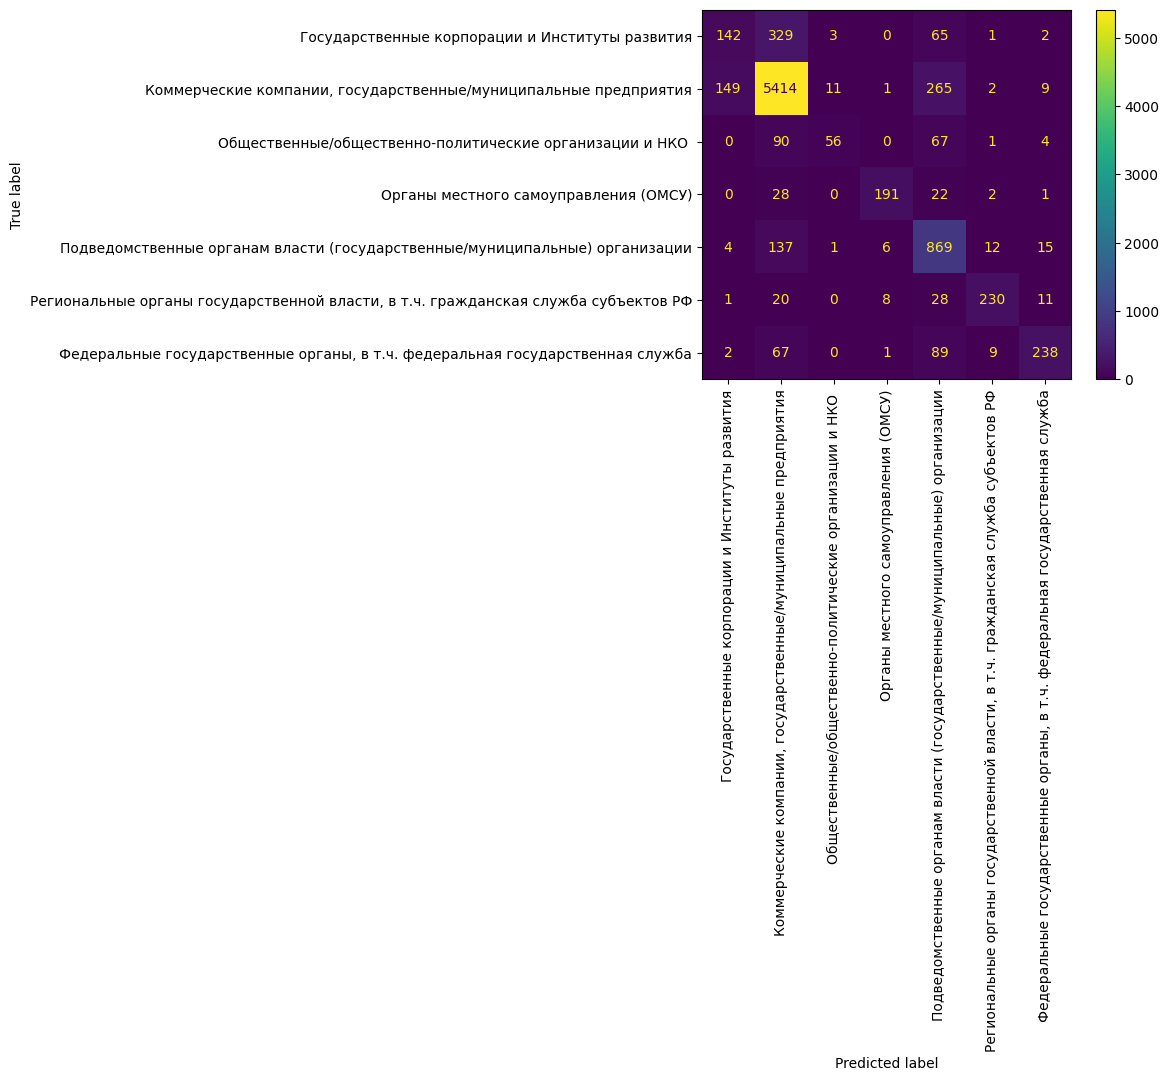

In [21]:
# compute metrics
metrics(pipes[0], X_val, y_val[0], LE[0])

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.00      0.00      0.00         0
           2       1.00      0.25      0.40         4
           3       0.89      0.92      0.91        26
           4       0.47      0.62      0.53        13
           5       0.94      0.86      0.90        71
           6       0.96      0.83      0.89        92

    accuracy                           0.80       213
   macro avg       0.75      0.52      0.55       213
weighted avg       0.92      0.80      0.84       213



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


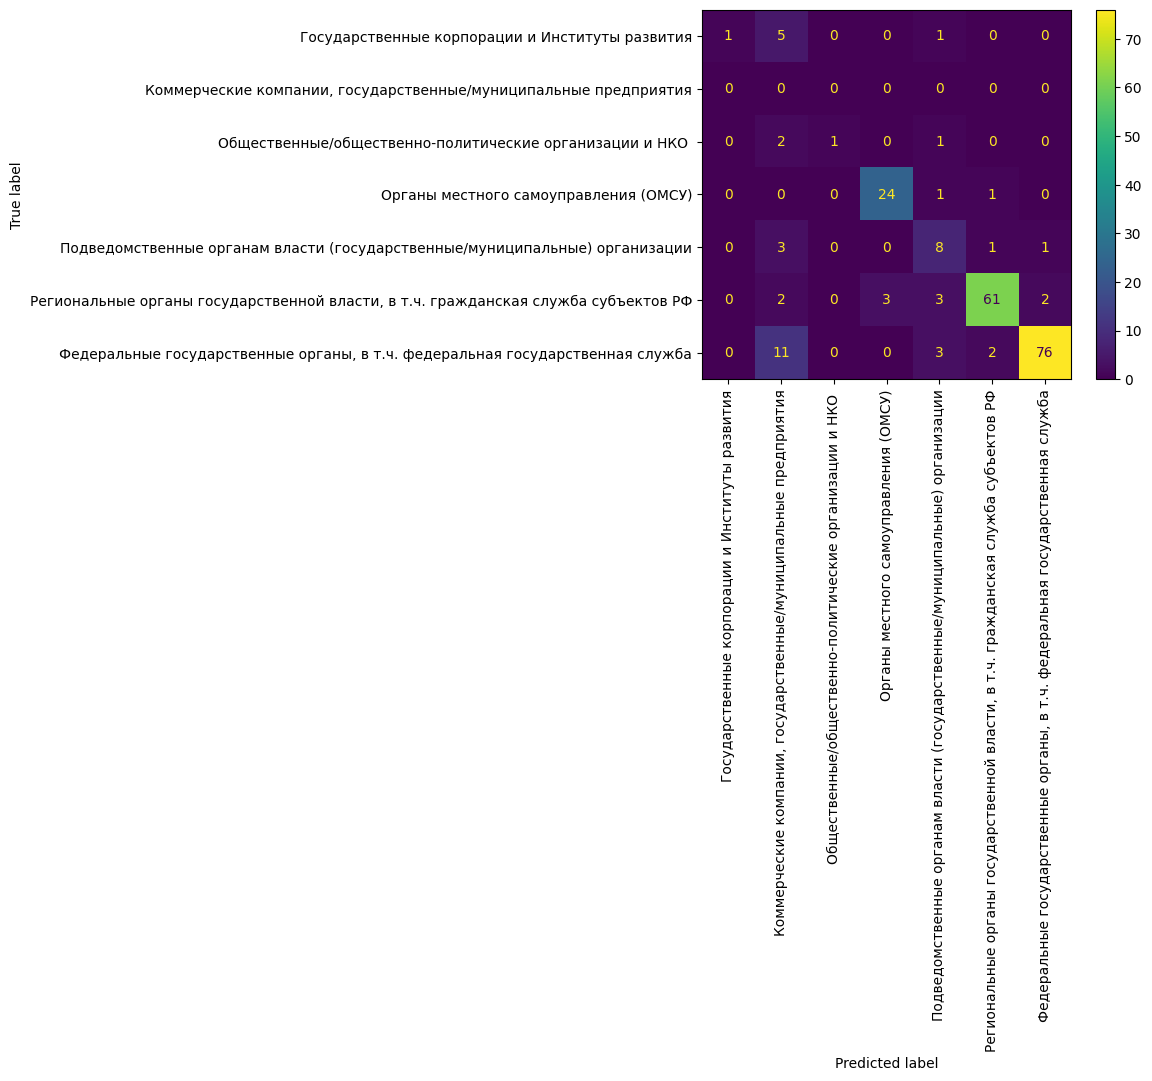

In [22]:
metrics(pipes[0], X_test, y_test[0], LE[0])


In [23]:
df

,Номер,Пол,Дата рождения,Федеральный округ,Регион,Страна проживания,Место работы,Наименование текущей должности,Уровень образования,Карьерная ступень по Классификатору ФОИР,Наименование выбранной типовой должности,Сфера деятельности по Классификатору ФОИР,Соответствует ли выбранная типовая текущей должности,Ручная проверка карьерной ступени,Разница по итогам проверки,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип","Уставный капитал, сумма",Тип по ОКОГУ,Среднесписочная численность сотрудников,Категория из реестра СМП,Сумма уплаченных налогов за 2020,age,label_a,label_b
0,9886272994,Мужской,1980-05-28,Центральный ФО,Московская,Россия,"ООО ""РЖД-Технологии""",Директор по стратегии,Кандидат наук,1,Руководитель подразделения/группы/команды на м...,"Коммерческие компании, государственные/муницип...",Можно считать аналогом с очень большой натяжкой,NaN,NaN,Деятельность консультативная и работы в област...,"Торговля оптовая компьютерами, периферийными у...",Торговля оптовая неспециализированная,"Торговля розничная компьютерами, периферийными...",УСТАВНЫЙ КАПИТАЛ,1.951980e+08,"Организации, учрежденные юридическими лицами и...",89.0,NaN,2.016288e+08,43.0,1,0
1,8010695393,Мужской,1977-10-09,Центральный ФО,Орловская,Россия,ПАО МегаФон,начальник,Два и более высших образований,3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,Деятельность в области связи на базе проводных...,Торговля оптовая программным обеспечением,Торговля оптовая неспециализированная,Деятельность в области связи на базе беспровод...,УСТАВНЫЙ КАПИТАЛ,6.200000e+07,Хозяйственные общества и товарищества с участи...,NaN,NaN,NaN,46.0,1,2
2,4851605917,Мужской,1991-12-08,Уральский ФО,Свердловская,Россия,"ООО ""Генная Хирургия""",Исполнительный директор,Два и более высших образований,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,Научные исследования и разработки в области ес...,Производство фармацевтических субстанций,Производство лекарственных препаратов и матери...,"Производство посуды для лабораторных, фармацев...",УСТАВНЫЙ КАПИТАЛ,8.400000e+04,"Организации, учрежденные юридическими лицами и...",0.0,МИКРОПРЕДПРИЯТИЕ,1.057117e+06,32.0,1,4
3,7512508692,Мужской,1980-01-19,Центральный ФО,Москва,Россия,ПАО «Вымпелком»,Директор по стратегии и долгосрочному планиров...,"Высшее, специалитет, магистратура",4,Руководитель управления корпоративной функции ...,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,Деятельность по предоставлению услуг подвижной...,Производство элементов электронной аппаратуры,Производство радиоэлектронных средств связи,Производство радио- и телевизионной передающей...,УСТАВНЫЙ КАПИТАЛ,2.885380e+05,Хозяйственные общества и товарищества с участи...,NaN,NaN,NaN,43.0,1,3
4,1007319237,Мужской,1976-01-11,Центральный ФО,Москва,Россия,Индивидуальный предприниматель,Предприниматель,"Высшее, специалитет, магистратура",1,Индивидуальный предприниматель/самозанятый,"Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43833,9101176879,Мужской,1986-01-01,Центральный ФО,Москва,Россия,Компания САР,Руководитель проекта,"Высшее, специалитет, магистратура",3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,Производство электроэнергии,Производство электроэнергии тепловыми электрос...,Производство пара и горячей воды (тепловой эне...,Строительство жилых и нежилых зданий,УСТАВНЫЙ КАПИТАЛ,2.773348e+09,"Организации, учрежденные юридическими лицами и...",459.0,NaN,2.193324e+08,37.0,1,2
43835,7582344260,Мужской,1

              precision    recall  f1-score   support

           0       0.43      0.52      0.47      2082
           1       0.45      0.21      0.29      1893
           2       0.41      0.69      0.51      2532
           3       0.34      0.20      0.25       449
           4       0.35      0.21      0.26      1008
           5       0.15      0.01      0.02       206
           6       0.22      0.01      0.02       186
           7       0.75      0.02      0.03       179
           8       0.17      0.02      0.04        46
           9       0.00      0.00      0.00        22

    accuracy                           0.41      8603
   macro avg       0.33      0.19      0.19      8603
weighted avg       0.41      0.41      0.37      8603



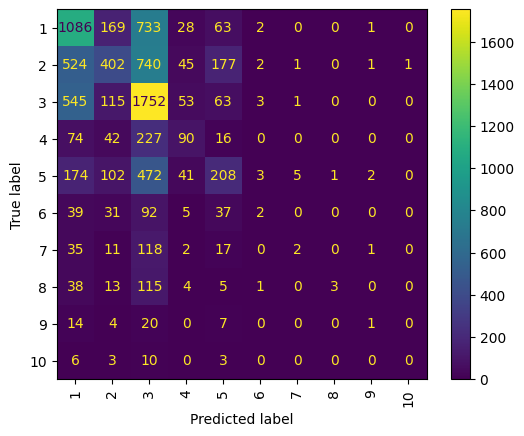

In [24]:
metrics(pipes[1], X_val, y_val[1], LE[1])

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       0.15      0.64      0.25        11
           1       0.33      0.39      0.36        33
           2       0.19      0.42      0.26        24
           3       0.39      0.76      0.51        29
           4       0.07      0.03      0.04        31
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         3

    accuracy                           0.25       213
   macro avg       0.10      0.20      0.13       213
weighted avg       0.14      0.25      0.17       213



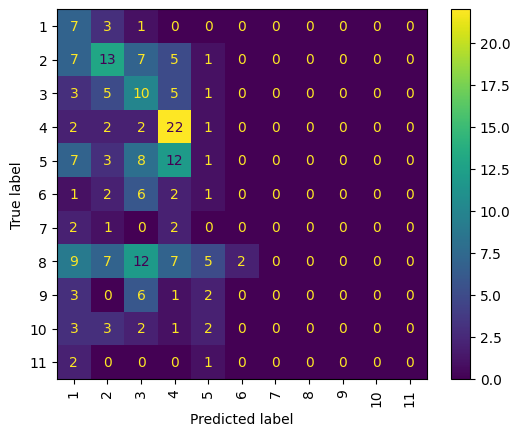

In [25]:
metrics(pipes[1], X_test, y_test[1], LE[1])

In [26]:
y_pred_1 = pipes[0].predict(X_val)

In [27]:
y_pred_1[y_pred_1 != y_val[0].values]

array([1, 1, 1, ..., 1, 1, 0])

In [28]:
y_val[0][y_pred_1 != y_val[0].values].values

array([0, 0, 0, ..., 3, 0, 1])

In [29]:
df_val[y_pred_1 != y_val[0].values]

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Федеральный округ,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age,Сфера деятельности по Классификатору ФОИР,Карьерная ступень по Классификатору ФОИР
12620,Деятельность в области права и бухгалтерского ...,"Издание книг, брошюр, рекламных буклетов и ана...",Деятельность информационных агентств,Деятельность в области права,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,Мужской,Белгородская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,"АО ""Корпорация ""развитие""",Генеральный директор,2.356099e+08,22.0,8.252864e+06,36.0,Государственные корпорации и Институты развития,6
37109,Производство электроэнергии атомными электрост...,Передача электроэнергии и технологическое прис...,Распределение электроэнергии,Производство пара и горячей воды (тепловой эне...,УСТАВНЫЙ КАПИТАЛ,Государственная корпорация по атомной энергии ...,NaN,Мужской,Курская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,Курская атомная станция,Начальник смены атомной станции,8.303139e+11,NaN,NaN,40.0,Государственные корпорации и Институты развития,7
26346,"Торговля оптовая твердым, жидким и газообразны...","Производство прочих химических продуктов, не в...",Торговля оптовая парфюмерными и косметическими...,Торговля оптовая прочими потребительскими това...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Женский,NaN,Австралия,Два и более высших образований,NaN,Компания «Мир Газа»,Бизнес Ассистент Генерального Директора,3.000000e+04,NaN,NaN,38.0,Государственные корпорации и Институты развития,5
23903,Передача электроэнергии и технологическое прис...,Ремонт электронного и оптического оборудования,Распределение электроэнергии,Хранение и складирование нефти и продуктов ее ...,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,Мужской,Тверская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,"ПАО ""МРСК ЦЕНТРА"" ""ТВЕРЬЭНЕРГО""",Начальниу УСЛЭП,4.221794e+09,NaN,NaN,51.0,Государственные корпорации и Институты развития,5
13625,Производство турбин,Производство гидравлического и пневматического...,Торговля оптовая прочими машинами и оборудованием,Деятельность по финансовой аренде (лизингу/суб...,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,Мужской,Санкт-Петербург,Россия,"Высшее, специалитет, магистратура",Северо-Западный ФО,"ООО ""Турбинные технологии ААЭМ""",Ведущий менеджер по качеству,3.543400e+09,284.0,1.625382e+09,32.0,"Коммерческие компании, государственные/муницип...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16184,Деятельность железнодорожного транспорта: груз...,Лесоводство и прочая лесохозяйственная деятель...,"Добыча декоративного и строительного камня, из...",Добыча и первичная обработка известняка и гипс...,УСТАВНЫЙ КАПИТАЛ,"Открытое акционерное общество ""Российские желе...",NaN,Мужской,Санкт-Петербург,Россия,"Высшее, специалитет, магистратура",Северо-Западный ФО,"ОАО ""РЖД""",заместитель начальника службы - начальник отдела,3.245346e+12,NaN,NaN,39.0,"Коммерческие компании, государственные/муницип...",3
21444,Научные исследования и разработки в области ес...,Прочие виды полиграфической деятельности,"Производство прочих изделий, не включенных в д...",Ремонт машин и оборудования,УСТАВНЫЙ ФОНД,NaN,NaN,Мужской,Московская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,ФГУП ЦИАМ им. П.И. Баранова,Заместитель начальника отделения,3.698684e+09,NaN,NaN,39.0,"Федеральные государственные органы, в т.ч. фед...",6
21639,Производство прочих машин специального назначения,"Строительство кораблей, судов и плавучих конст...",Ремонт 

In [30]:
df_train

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Федеральный округ,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age,Сфера деятельности по Классификатору ФОИР,Карьерная ступень по Классификатору ФОИР
12068,"Строительство кораблей, судов и плавучих конст...",Прочие виды полиграфической деятельности,Изготовление печатных форм и подготовительная ...,Производство изделий из бетона для использован...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,Мужской,Приморский,Россия,"Высшее, специалитет, магистратура",Дальневосточный ФО,"ООО ""ССК ""Звезда""",Начальник отдела бизнес-анализа,1.731720e+11,4702.0,NaN,33.0,"Коммерческие компании, государственные/муницип...",3
21952,Передача электроэнергии и технологическое прис...,Ремонт электронного и оптического оборудования,Распределение электроэнергии,Хранение и складирование нефти и продуктов ее ...,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,Мужской,Смоленская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,"Филиал ПАО ""МРСК Центра""-""Смоленскэнерго""",Начальник участка метрологии и качества электр...,4.221794e+09,NaN,NaN,51.0,"Коммерческие компании, государственные/муницип...",3
18309,Деятельность органов государственной власти су...,NaN,NaN,NaN,NaN,Законодательная (представительная) власть су...,NaN,NaN,NaN,NaN,Среднее профессиональное,NaN,Законодательное собрание Свердловской области,Помощник депутата,NaN,NaN,NaN,NaN,"Региональные органы государственной власти, в ...",2
23873,Деятельность в области права и бухгалтерского ...,"Сбор и заготовка дикорастущих плодов, ягод",Сбор и заготовка дикорастущих орехов,Распиловка и строгание древесины,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Мужской,Саратовская,Россия,"Высшее, специалитет, магистратура",Приволжский ФО,Центральный офис,Руководитель учебного отдела,1.000000e+04,12.0,1457689.09,34.0,"Коммерческие компании, государственные/муницип...",3
13571,Производство деревянной тары,Деятельность автомобильного грузового транспор...,Деятельность по складированию и хранению,Покупка и продажа собственного недвижимого иму...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Женский,Нижегородская,Россия,"Высшее, специалитет, магистратура",Приволжский ФО,Оупен груп,Региональный менеджер проекта,2.000000e+04,1.0,159498.00,43.0,"Коммерческие компании, государственные/муницип...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37889,Денежное посредничество прочее,"Деятельность, связанная с использованием вычис...",NaN,NaN,УСТАВНЫЙ КАПИТАЛ,Центральный банк Российской Федерации,NaN,Женский,Краснодарский,Россия,Два и более высших образований,Южный ФО,Альфа-банк,Руководитель направления развития розничных пр...,5.958762e+10,NaN,NaN,40.0,"Коммерческие компании, государственные/муницип...",5
26661,"Торговля розничная мебелью, осветительными при...","Производство готовых текстильных изделий, кром...","Производство деревянных рам для картин, фотогр...",Сбор и обработка сточных вод,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,Мужской,Москва,Россия,"Высшее, специалитет, магистратура",Центральный ФО,ООО Леруа Мерлен Восток,"Директор по сорсингу, Директор по работе с рег...",5.980400e+09,NaN,NaN,50.0,"Коммерческие компании, государственные/муницип...",8
8077,Деятельность по управлению холдинг-компаниями,Разработка компьютерного программного обеспечения,"Деятельность, связанная с использованием вычис...",Деятельность в области права и бухгалтерского ...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,Мужской,Москва,Россия,"Высшее, специ

In [31]:
df_val[y_pred_1 != y_val[0]]

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Федеральный округ,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age,Сфера деятельности по Классификатору ФОИР,Карьерная ступень по Классификатору ФОИР
12620,Деятельность в области права и бухгалтерского ...,"Издание книг, брошюр, рекламных буклетов и ана...",Деятельность информационных агентств,Деятельность в области права,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,Мужской,Белгородская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,"АО ""Корпорация ""развитие""",Генеральный директор,2.356099e+08,22.0,8.252864e+06,36.0,Государственные корпорации и Институты развития,6
37109,Производство электроэнергии атомными электрост...,Передача электроэнергии и технологическое прис...,Распределение электроэнергии,Производство пара и горячей воды (тепловой эне...,УСТАВНЫЙ КАПИТАЛ,Государственная корпорация по атомной энергии ...,NaN,Мужской,Курская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,Курская атомная станция,Начальник смены атомной станции,8.303139e+11,NaN,NaN,40.0,Государственные корпорации и Институты развития,7
26346,"Торговля оптовая твердым, жидким и газообразны...","Производство прочих химических продуктов, не в...",Торговля оптовая парфюмерными и косметическими...,Торговля оптовая прочими потребительскими това...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Женский,NaN,Австралия,Два и более высших образований,NaN,Компания «Мир Газа»,Бизнес Ассистент Генерального Директора,3.000000e+04,NaN,NaN,38.0,Государственные корпорации и Институты развития,5
23903,Передача электроэнергии и технологическое прис...,Ремонт электронного и оптического оборудования,Распределение электроэнергии,Хранение и складирование нефти и продуктов ее ...,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,Мужской,Тверская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,"ПАО ""МРСК ЦЕНТРА"" ""ТВЕРЬЭНЕРГО""",Начальниу УСЛЭП,4.221794e+09,NaN,NaN,51.0,Государственные корпорации и Институты развития,5
13625,Производство турбин,Производство гидравлического и пневматического...,Торговля оптовая прочими машинами и оборудованием,Деятельность по финансовой аренде (лизингу/суб...,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,Мужской,Санкт-Петербург,Россия,"Высшее, специалитет, магистратура",Северо-Западный ФО,"ООО ""Турбинные технологии ААЭМ""",Ведущий менеджер по качеству,3.543400e+09,284.0,1.625382e+09,32.0,"Коммерческие компании, государственные/муницип...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16184,Деятельность железнодорожного транспорта: груз...,Лесоводство и прочая лесохозяйственная деятель...,"Добыча декоративного и строительного камня, из...",Добыча и первичная обработка известняка и гипс...,УСТАВНЫЙ КАПИТАЛ,"Открытое акционерное общество ""Российские желе...",NaN,Мужской,Санкт-Петербург,Россия,"Высшее, специалитет, магистратура",Северо-Западный ФО,"ОАО ""РЖД""",заместитель начальника службы - начальник отдела,3.245346e+12,NaN,NaN,39.0,"Коммерческие компании, государственные/муницип...",3
21444,Научные исследования и разработки в области ес...,Прочие виды полиграфической деятельности,"Производство прочих изделий, не включенных в д...",Ремонт машин и оборудования,УСТАВНЫЙ ФОНД,NaN,NaN,Мужской,Московская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,ФГУП ЦИАМ им. П.И. Баранова,Заместитель начальника отделения,3.698684e+09,NaN,NaN,39.0,"Федеральные государственные органы, в т.ч. фед...",6
21639,Производство прочих машин специального назначения,"Строительство кораблей, судов и плавучих конст...",Ремонт 

In [32]:
df_val[y_pred_1 != y_val[0]]['Вид экономической деятельности, ОКВЭД'].iloc[0]

'Деятельность в области права и бухгалтерского учета'

In [33]:
df_train[df_train['Вид экономической деятельности, ОКВЭД'] == df_val[y_pred_1 != y_val[0]]['Вид экономической деятельности, ОКВЭД'].iloc[0]]

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Федеральный округ,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age,Сфера деятельности по Классификатору ФОИР,Карьерная ступень по Классификатору ФОИР
23873,Деятельность в области права и бухгалтерского ...,"Сбор и заготовка дикорастущих плодов, ягод",Сбор и заготовка дикорастущих орехов,Распиловка и строгание древесины,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Мужской,Саратовская,Россия,"Высшее, специалитет, магистратура",Приволжский ФО,Центральный офис,Руководитель учебного отдела,1.000000e+04,12.0,1.457689e+06,34.0,"Коммерческие компании, государственные/муницип...",3
37896,Деятельность в области права и бухгалтерского ...,Деятельность в области права,NaN,NaN,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Женский,Свердловская,Россия,"Высшее, специалитет, магистратура",Уральский ФО,"ООО ""Юридическое бюро ""Вэритас""",директор,1.000000e+04,5.0,3.434392e+06,40.0,"Коммерческие компании, государственные/муницип...",2
13684,Деятельность в области права и бухгалтерского ...,Прочие виды полиграфической деятельности,Торговля оптовая газетами и журналами,Торговля оптовая неспециализированная,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Женский,Москва,Россия,Студент выпускного курса специалитета/магистра...,Центральный ФО,ЦМБН,Начальник отдела,5.000000e+04,4.0,9.739200e+04,32.0,"Коммерческие компании, государственные/муницип...",1
9289,Деятельность в области права и бухгалтерского ...,"Деятельность, связанная с использованием вычис...","Деятельность по обработке данных, предоставлен...",Деятельность по созданию и использованию баз д...,УСТАВНЫЙ КАПИТАЛ,"Публичное акционерное общество ""Газпром нефть""",NaN,Женский,Санкт-Петербург,Россия,"Высшее, специалитет, магистратура",Северо-Западный ФО,Газпромнефть Бизнес-Сервис,Ведущий специалист,2.325000e+05,NaN,NaN,29.0,"Коммерческие компании, государственные/муницип...",3
14247,Деятельность в области права и бухгалтерского ...,Производство гипсовых изделий для использовани...,"Производство прочих изделий из гипса, бетона и...",Деятельность в области права,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",СРЕДНЕЕ ПРЕДПРИЯТИЕ,Мужской,Волгоградская,Россия,"Высшее, специалитет, магистратура",Южный ФО,"ООО ""УК ""ВОЛМА""",Директор по логистике,1.000000e+05,231.0,1.056561e+08,41.0,"Коммерческие компании, государственные/муницип...",2
39165,Деятельность в области права и бухгалтерского ...,"Издание книг, брошюр, рекламных буклетов и ана...",Деятельность информационных агентств,Деятельность в области права,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,Женский,Белгородская,Россия,"Высшее, специалитет, магистратура",Центральный ФО,"АО ""Корпорация Развитие """,Руководитель направления НТИ проекта Точка кип...,2.356099e+08,22.0,8.252864e+06,27.0,Общественные/общественно-политические организа...,5
34378,Деятельность в области права и бухгалтерского ...,Деятельность издательская,Разработка компьютерного программного обеспечения,Деятельность консультативная и работы в област...,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,Женский,Самарская,Россия,"Высшее, бакалавриат",Приволжский ФО,"ООО ""Эос""",Руководитель розничной сети ПФО,6.450000e+06,NaN,NaN,43.0,"Коммерческие компании, государственные/муницип...",3
5948,Деятельность в области права и бухгалтерского ...,Деятельность по предоставлению прочих вспомога...,"Образование дополнительное детей и взрослых, н...",NaN,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Мужской,Нов

Проверим качество только по данным из 2х колонок

In [34]:
df_val[['Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Федеральный округ']] = None

In [35]:
df_val

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Федеральный округ,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age,Сфера деятельности по Классификатору ФОИР,Карьерная ступень по Классификатору ФОИР
35966,Подготовка кадров высшей квалификации,Деятельность полиграфическая и предоставление ...,Копирование записанных носителей информации,Торговля розничная книгами в специализированны...,NaN,Органы исполнительной власти субъектов Российс...,NaN,None,None,None,None,None,"ГАУ ДПО ""Институт усовершенствования врачей"" М...",Ректор,NaN,NaN,NaN,49.0,Подведомственные органам власти (государственн...,3
10967,Строительство жилых и нежилых зданий,"Добыча прочих полезных ископаемых, не включенн...",Распиловка и строгание древесины,Предоставление услуг по пропитке древесины,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,None,None,None,None,None,ООО «Прайдекс Констракшн»,Заместитель генерального директора по безопасн...,1.000000e+05,3093.0,3.462817e+09,42.0,"Коммерческие компании, государственные/муницип...",5
12620,Деятельность в области права и бухгалтерского ...,"Издание книг, брошюр, рекламных буклетов и ана...",Деятельность информационных агентств,Деятельность в области права,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,None,None,None,None,None,"АО ""Корпорация ""развитие""",Генеральный директор,2.356099e+08,22.0,8.252864e+06,36.0,Государственные корпорации и Институты развития,6
11888,Деятельность органов государственной власти су...,NaN,NaN,NaN,NaN,Уполномоченные по правам человека субъектов Р...,NaN,None,None,None,None,None,Уполномоченный по правам человека в Самарской ...,консультант аппарата,NaN,NaN,NaN,44.0,"Региональные органы государственной власти, в ...",2
32404,Образование высшее,Прочие виды полиграфической деятельности,Деятельность брошюровочно- переплетная и отдел...,Копирование записанных носителей информации,NaN,Правительство Российской Федерации,NaN,None,None,None,None,None,НИУ ВШЭ,цифровой / учебный ассистент,NaN,NaN,NaN,25.0,Подведомственные органам власти (государственн...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,Деятельность головных офисов,Покупка и продажа собственного недвижимого иму...,Покупка и продажа земельных участков,Аренда и управление собственным или арендованн...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,None,None,None,None,None,"ООО ""МАЯК""",Директор,1.700100e+09,1.0,7.730324e+04,49.0,"Коммерческие компании, государственные/муницип...",2
36069,Производство электрической распределительной и...,"Производство замков, петель",Производство частей и принадлежностей летатель...,Передача электроэнергии и технологическое прис...,NaN,"Хозяйственные общества, образованные из госуд...",NaN,None,None,None,None,None,"ОАО ""Уральский завод электрических соединителей""",Главный технолог,NaN,NaN,NaN,40.0,"Коммерческие компании, государственные/муницип...",2
24007,Передача электроэнергии и технологическое прис...,Ремонт электронного и оптического оборудования,Распределение электроэнергии,Хранение и складирование нефти и продуктов ее ...,УСТАВНЫЙ КАПИТАЛ,Хозяйственные общества и товарищества с участи...,NaN,None,None,None,None,None,филиал ПАО МРСК Центра Воронежэнерго,Начальник отдела,4.221794e+09,NaN,NaN,43.0,"Коммерческие компании, государственные/муницип...",3
24715,"Торговля розничная компьютерами, периферийными...",Производство компьютеров,Производство периферийного оборудования,Производство запоминающих устройств и прочих у...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,None,None,None,None,None,ООО Ситилинк,Маркетолог,5.856268e+09,NaN,NaN,28.0,"Коммерч

In [23]:
X_val = data_prepare.transform(df_val)

  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       0.38      0.63      0.48       840
           1       0.39      0.24      0.29       677
           2       0.39      0.57      0.46       922
           3       0.46      0.22      0.30       210
           4       0.43      0.11      0.18       440
           5       0.00      0.00      0.00        91
           6       0.00      0.00      0.00        81
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00        27

    accuracy                           0.39      3361
   macro avg       0.19      0.16      0.16      3361
weighted avg       0.37      0.39      0.35      3361



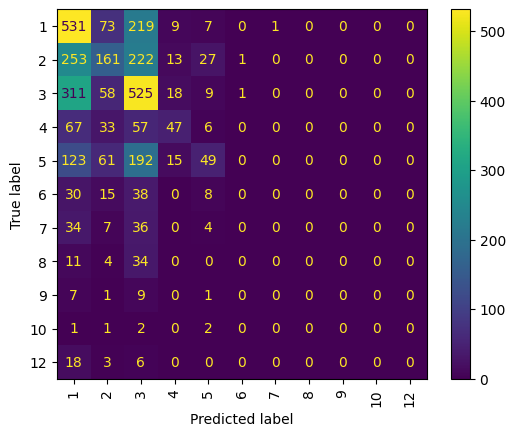

In [24]:
metrics(pipes[1], X_val, y_val[1], LE[1])

              precision    recall  f1-score   support

           0       0.59      0.30      0.40       206
           1       0.91      0.88      0.89      1793
           2       0.00      0.00      0.00        27
           3       0.77      0.45      0.57       125
           4       0.87      0.85      0.86       144
           5       0.62      0.89      0.73       613
           6       0.87      0.83      0.85       250
           7       0.75      0.67      0.70       203

    accuracy                           0.81      3361
   macro avg       0.67      0.61      0.63      3361
weighted avg       0.81      0.81      0.80      3361



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

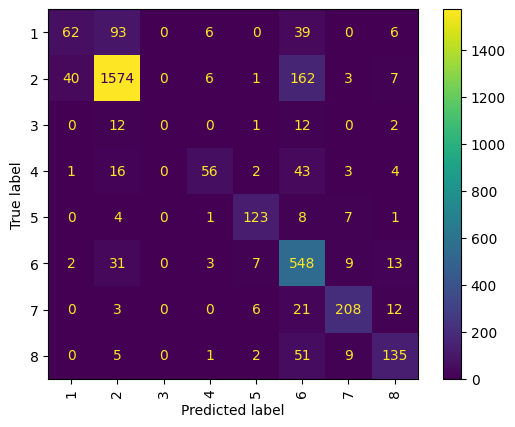

In [25]:
metrics(pipes[0], X_val, y_val[0], LE[1])

In [26]:
df['label_b'].value_counts(normalize=True)[:5].sum()

0.9199500059516723

In [ ]:

# save pipes and transformer
joblib.dump(pipes, 'models/pipelines.joblib')

# data_prepare.steps[0][1].transformers[1][1].to_device(torch.device('cpu'))
joblib.dump(data_prepare, 'models/data_prepare.joblib')
joblib.dump(LE, 'models/label_encoders.joblib')

print('FINISH')